# Modelo

### Librerías y carga del dataset

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

import matplotlib.pyplot as plt
import pickle
import os

# Directorio que contiene los archivos pkl
directorio = '../data/'  # Actualiza con la ruta correcta

# Lista para almacenar los DataFrames de los archivos pkl
dataframes = []

# Recorre los archivos en el directorio
for archivo in os.listdir(directorio):
    if archivo.endswith('.pkl'):
        ruta_archivo = os.path.join(directorio, archivo)
        with open(ruta_archivo, 'rb') as f:
            data = pickle.load(f)
        dataframes.append(data)

# Combina los DataFrames en uno solo
data = pd.concat(dataframes, ignore_index=True)

### Datos sin procesar

In [10]:
print(data.head())
print("filas-data-sucia: ", len(data))

   TRANSACTION_ID TIEMPO_DESDE_ULTIMA_TX_S DIA_TX CLIENTE_ID TERMINAL_ID  \
0          109006                  1728250     20       2537         316   
1          109007                  1728315     20       4606          86   
2          109008                  1728420     20       7507         271   
3          109009                  1728502     20       5030         281   
4          109010                  1728805     20       4739         280   

   MONTO_TX         TX_DATETIME    year  month   day  hour  minute  \
0  63406.57 2023-01-21 00:04:10  2023.0    1.0  21.0   0.0     4.0   
1  47177.10 2023-01-21 00:05:15  2023.0    1.0  21.0   0.0     5.0   
2  41771.86 2023-01-21 00:07:00  2023.0    1.0  21.0   0.0     7.0   
3  40278.29 2023-01-21 00:08:22  2023.0    1.0  21.0   0.0     8.0   
4  39548.41 2023-01-21 00:13:25  2023.0    1.0  21.0   0.0    13.0   

   x_pos_terminal  y_pos_terminal  TX_FRAUD  TX_FRAUD_SCENARIO  
0       22.600080       40.416937         0              

### Datos filtrados

In [11]:
data = data.drop('TRANSACTION_ID', axis=1)
data = data.drop('CLIENTE_ID', axis=1)
data = data[data['TX_FRAUD'] == 1]
data = data.sort_values(by=['TX_DATETIME'])
print(data.head())
print("total-filas: ",len(data) )

       TIEMPO_DESDE_ULTIMA_TX_S DIA_TX TERMINAL_ID   MONTO_TX  \
125412                     1524      0         429  139447.11   
125417                     1805      0          93   92739.05   
125419                     1911      0         380  115776.96   
125432                     2544      0         233  139610.64   
125433                     2552      0         210  132291.02   

               TX_DATETIME    year  month  day  hour  minute  x_pos_terminal  \
125412 2023-01-01 00:25:24  2023.0    1.0  1.0   0.0    25.0        3.203366   
125417 2023-01-01 00:30:05  2023.0    1.0  1.0   0.0    30.0       49.140856   
125419 2023-01-01 00:31:51  2023.0    1.0  1.0   0.0    31.0       45.234308   
125432 2023-01-01 00:42:24  2023.0    1.0  1.0   0.0    42.0       25.412377   
125433 2023-01-01 00:42:32  2023.0    1.0  1.0   0.0    42.0       28.550428   

        y_pos_terminal  TX_FRAUD  TX_FRAUD_SCENARIO  
125412       17.765518         1                  1  
125417        9.0806

### Random Forest

/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Best n_estimators: 500


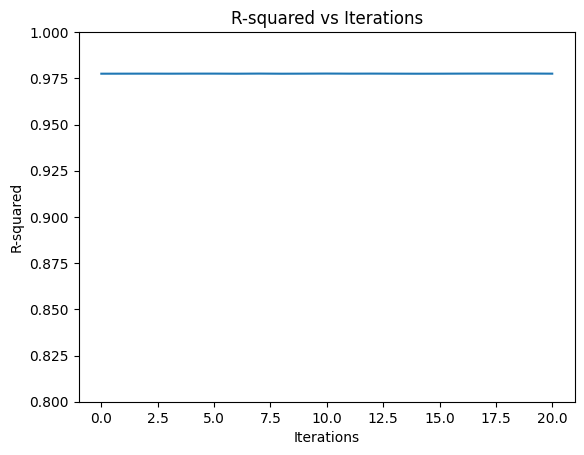

In [12]:
from sklearn.ensemble import RandomForestRegressor
from numpy import inf
from sklearn.metrics import r2_score
# Variables de entrada
X = data[['x_pos_terminal', 'y_pos_terminal','month', 'day', 'hour', 'minute']]
# Variables objetivo
y = data[['x_pos_terminal', 'y_pos_terminal','month','day', 'hour', 'minute']]

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_estimators_range = [10, 50, 100, 200, 500]
best_r2_score = -inf
best_n_estimators = None

# Probar diferentes valores de n_estimators
for n_estimators in n_estimators_range:
    model = RandomForestRegressor(n_estimators=n_estimators, oob_score=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    # Comparar el rendimiento actual con el mejor rendimiento hasta ahora
    if r2 > best_r2_score:
        best_r2_score = r2
        best_n_estimators = n_estimators

print("Best n_estimators:", best_n_estimators)

# Crear y entrenar el modelo de regresión
n_iterations = 20
model = RandomForestRegressor(oob_score=True, min_samples_split=5, n_estimators=best_n_estimators)
model.fit(X_train, y_train)

# Obtener el R-squared inicial
initial_r2 = model.oob_score_

# Lista para almacenar los R-squared en cada etapa del entrenamiento
r2_scores = [initial_r2]

# Entrenamiento iterativo del modelo
for i in range(n_iterations):
    model.estimators_ = model.estimators_[:best_n_estimators]  # Restringir el número de estimadores para la iteración actual
    model.fit(X_train, y_train)
    r2_score = model.oob_score_
    r2_scores.append(r2_score)

# Crear el gráfico de progreso del R-squared
plt.plot(range(n_iterations + 1), r2_scores)
plt.xlabel('Iterations')
plt.ylabel('R-squared')
plt.title('R-squared vs Iterations')
plt.ylim([0.8, 1])
plt.show()

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

In [13]:
y_pred_rounded = y_pred.copy()  # Copia los valores predichos

# Redondea los valores a enteros en las últimas 4 columnas
y_pred_rounded[:, -4:] = y_pred_rounded[:, -4:].round().astype(int)

print(y_pred_rounded)
rounded_df = pd.DataFrame(y_pred_rounded, columns=y_test.columns)
rounded_df.to_csv('../output/predicciones.csv', index=False)

[[40.35883652 17.34346908  1.          6.          8.         18.        ]
 [40.71744583 33.97438445  1.         12.         15.         11.        ]
 [46.68881241 45.5141884   1.         21.         11.         28.        ]
 ...
 [ 3.86189715 34.00081935  1.         13.         15.         40.        ]
 [47.99398288 11.78721574  1.          5.         16.         19.        ]
 [ 5.49665315  8.56372218  1.         13.         12.          4.        ]]


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calcular las métricas
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)


Mean Squared Error (MSE): 1.6119961497248696
Mean Absolute Error (MAE): 0.8816127032747659
R-squared: 0.9779884110356835


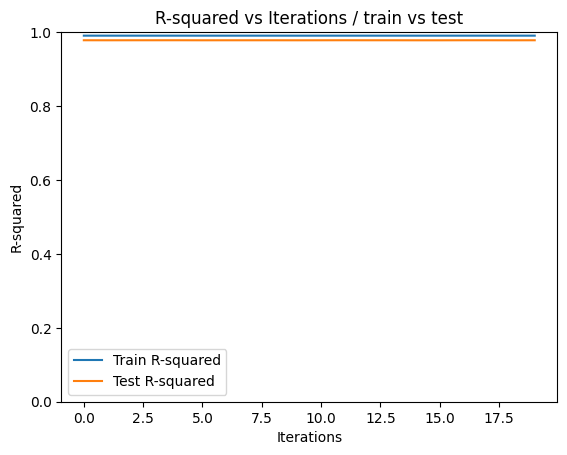

In [15]:
import matplotlib.pyplot as plt

# Crear listas para almacenar los valores de R-squared
train_r2_scores = []
test_r2_scores = []

# Entrenar el modelo y calcular el R-squared en cada iteración
for i in range(n_iterations):
    model.fit(X_train, y_train)
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Crear el gráfico de progreso del R-squared
plt.plot(range(n_iterations), train_r2_scores, label='Train R-squared')
plt.plot(range(n_iterations), test_r2_scores, label='Test R-squared')
plt.xlabel('Iterations')
plt.ylabel('R-squared')
plt.title('R-squared vs Iterations / train vs test')
plt.ylim([0, 1])
plt.legend()
plt.show()

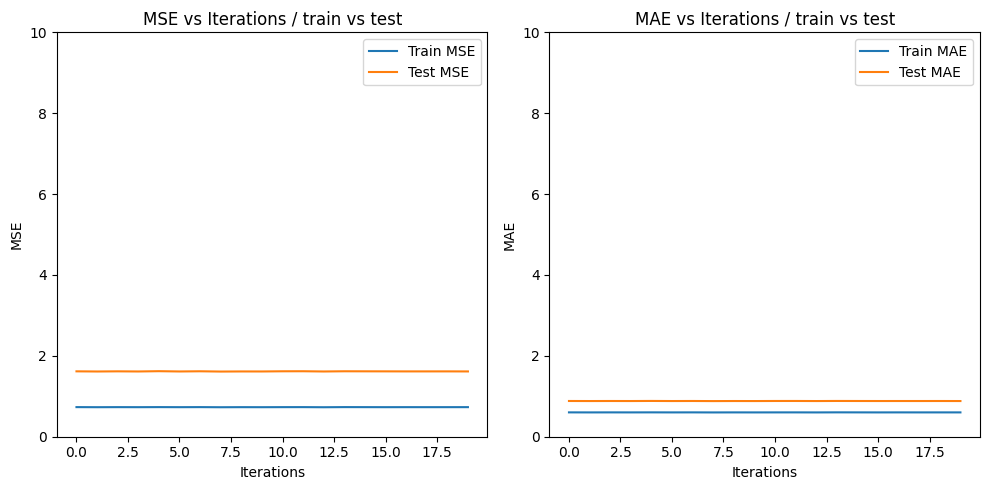

In [16]:
# Crear listas para almacenar los valores del MSE y el MAE
train_mse_scores = []
test_mse_scores = []
train_mae_scores = []
test_mae_scores = []

# Entrenar el modelo y calcular el MSE y el MAE en cada iteración
for i in range(n_iterations):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)

# Crear los gráficos de progreso del MSE y el MAE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(n_iterations), train_mse_scores, label='Train MSE')
plt.plot(range(n_iterations), test_mse_scores, label='Test MSE')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('MSE vs Iterations / train vs test')
plt.ylim([0, 10])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(n_iterations), train_mae_scores, label='Train MAE')
plt.plot(range(n_iterations), test_mae_scores, label='Test MAE')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('MAE vs Iterations / train vs test')
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
plt.show()

### Validación

In [28]:
validacion_directorio = '../validation/'

dataframe_validation = []

for archivo in os.listdir(validacion_directorio):
    if archivo.endswith('.pkl'):
        ruta_archivo = os.path.join(validacion_directorio, archivo)
        with open(ruta_archivo, 'rb') as f:
            data_val = pickle.load(f)
        dataframe_validation.append(data_val)

# Combina los DataFrames en uno solo
data_val = pd.concat(dataframe_validation, ignore_index=True)

In [29]:
data_val = data_val.drop('TRANSACTION_ID', axis=1)
data_val = data_val.drop('CLIENTE_ID', axis=1)
data_val = data_val[data_val['TX_FRAUD'] == 1]
data_val = data_val.sort_values(by=['TX_DATETIME'])
print(data_val.head())
print("total-filas: ",len(data_val) )

    TIEMPO_DESDE_ULTIMA_TX_S DIA_TX TERMINAL_ID   MONTO_TX  \
756                     1524      0          98  139447.11   
757                     1805      0          46   92739.05   
759                     5559      0          29   90911.63   
760                     6890      0          97   88554.72   
766                     9344      0          86   19788.93   

            TX_DATETIME    year  month  day  hour  minute  x_pos_terminal  \
756 2023-01-01 00:25:24  2023.0    1.0  1.0   0.0    25.0        3.203366   
757 2023-01-01 00:30:05  2023.0    1.0  1.0   0.0    30.0       49.952026   
759 2023-01-01 01:32:39  2023.0    1.0  1.0   1.0    32.0       41.457345   
760 2023-01-01 01:54:50  2023.0    1.0  1.0   1.0    54.0       45.843067   
766 2023-01-01 02:35:44  2023.0    1.0  1.0   2.0    35.0       14.022200   

     y_pos_terminal  TX_FRAUD  TX_FRAUD_SCENARIO  
756       17.765518         1                  1  
757       11.804449         1                  1  
759       4

In [30]:
X_val = data_val[['x_pos_terminal', 'y_pos_terminal','month', 'day', 'hour', 'minute']]
# Variables objetivo
y_val = data_val[['x_pos_terminal', 'y_pos_terminal','month','day', 'hour', 'minute']]

# Realizar predicciones en el conjunto de prueba
y_pred_val = model.predict(X_val)

y_pred_val_original = y_pred_val.copy()  # Copia los valores predichos

y_pred_rounded_val = y_pred_val.copy()  # Copia los valores predichos

# Redondea los valores a enteros en las últimas 4 columnas
y_pred_rounded_val[:, -4:] = y_pred_rounded_val[:, -4:].round().astype(int)

print(y_pred_rounded_val)
rounded_df_val = pd.DataFrame(y_pred_rounded_val, columns=y_val.columns)
rounded_df_val.to_csv('../output/predicciones_val.csv', index=False)

# Calcular las métricas
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Imprimir las métricas
print("Mean Squared Error (MSE):", mse_val)
print("Mean Absolute Error (MAE):", mae_val)
print("R-squared:", r2_val)


[[ 3.11342995 17.33338887  1.          4.          3.         25.        ]
 [47.49212729 11.31785872  1.          6.          6.         33.        ]
 [43.92876529 46.42314276  1.          4.          5.         34.        ]
 ...
 [ 4.88293463 37.56611336  1.         28.         20.         19.        ]
 [40.00362131 20.05112734  1.         26.         21.         25.        ]
 [26.23122964 44.53023752  1.         28.         22.         41.        ]]
Mean Squared Error (MSE): 1.840390595018424
Mean Absolute Error (MAE): 0.9044227236646177
R-squared: 0.9774224472974847


In [31]:
print(y_pred_val_original)

[[ 3.11342995 17.33338887  1.          3.56894264  3.28972475 25.1388487 ]
 [47.49212729 11.31785872  1.          5.68769473  5.82185188 32.82444473]
 [43.92876529 46.42314276  1.          4.14346277  5.13939841 33.76419481]
 ...
 [ 4.88293463 37.56611336  1.         27.93415563 20.02534726 18.64561154]
 [40.00362131 20.05112734  1.         25.79091639 21.30797285 24.78733721]
 [26.23122964 44.53023752  1.         28.33042453 21.99611739 40.60471053]]
